In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
state = 'AL'    # 2-letter state code
level = 'tract' # county, tract, block

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # voting age population (VAP)
    G.nodes[node]['VAP'] = G.nodes[node]['P0030001']
    
    # Black or African American alone:
    G.nodes[node]['BVAP'] = G.nodes[node]['P0030004']
    
    # Black or African American (among two races)
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030011']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030016']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030017']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030018']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030019']
    
    # Black or African American (among three races)
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030027']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030028']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030029']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030030']

    G.nodes[node]['BVAP'] += G.nodes[node]['P0030037']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030038']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030039']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030040']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030041']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030042']
    
    # Black or African American (among four races)
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030048']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030049']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030050']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030051']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030052']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030053']
    
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030058']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030059']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030060']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030061']
    
    # Black or African American (among five races)
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030064']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030065']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030066']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030067']
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030069']
    
    # Black or African American (among fix races)
    G.nodes[node]['BVAP'] += G.nodes[node]['P0030071']

In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import congressional_districts_2020
k = congressional_districts_2020[state]

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 714166 and U = 721342 and k = 7


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when tract i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-27


In [5]:
# get county graph
filename = state + '_county.json'
GC = Graph.from_json( filepath + filename )

for node in GC.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    GC.nodes[node]['TOTPOP'] = GC.nodes[node]['P0010001']

gtn = { GC.nodes[i]['GEOID20'] : i for i in GC.nodes }

In [6]:
# split at most 1 county
splits = 1
whole = m.addVars(GC.nodes, vtype=GRB.BINARY)
some = m.addVars(GC.nodes, vtype=GRB.BINARY)
split = m.addVars(GC.nodes, vtype=GRB.BINARY)

m.addConstr( gp.quicksum(split) <= splits )
m.addConstrs( split[c] == some[c] - whole[c] for c in GC.nodes )

for i in G.nodes:
    g = G.nodes[i]['GEOID20'][0:5]
    c = gtn[g]
    m.addConstr( whole[c] <= x[i] )
    m.addConstr( x[i] <= some[c] )

In [7]:
# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

In [8]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [9]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [10]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [11]:
# black_vap >= 0.5 * total_vap
bvap = m.addVar()
vap = m.addVar()

m.addConstr( bvap == gp.quicksum( G.nodes[i]['BVAP'] * x[i] for i in G.nodes ) )
m.addConstr( vap == gp.quicksum( G.nodes[i]['VAP'] * x[i] for i in G.nodes ) )

m.addConstr( bvap >= 0.5 * vap )

<gurobi.Constr *Awaiting Model Update*>

In [12]:
# solve IP model
m.Params.TimeLimit = 600
m.optimize()

Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10977 rows, 9671 columns and 45411 nonzeros
Model fingerprint: 0x029011d5
Model has 1 quadratic constraint
Variable types: 5 continuous, 9666 integer (9666 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.36s
Presolved: 10977 rows, 9671 columns, 45411 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 9668 integer (9666 binary)

Root relaxation: objective 0.000000e+00, 5227 iterations, 1.47 seconds (0.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      

In [13]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)

# retrieve the districts and their populations
district = [i for i in G.nodes if x[i].x > 0.5] 
district_population = sum(G.nodes[i]["TOTPOP"] for i in district )

The inverse PP score is 2.3996344995332346
The PP score is 0.4167301312739566


In [14]:
print("black_vap =", round(bvap.x) )
print("total_vap =", round(vap.x) )
print("percentage =", round( 100 * bvap.x / vap.x ),"%" )

black_vap = 281711
total_vap = 562696
percentage = 50 %


In [15]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
filename = state + '_' + level + '.shp'
df = gpd.read_file( filepath + filename )

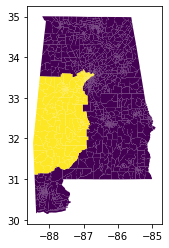

In [17]:
assignment = [ -1 for i in G.nodes ]
labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()

In [18]:
county_geoids = { G.nodes[i]['GEOID20'][0:5] for i in G.nodes }
county_pop = { g : 0 for g in county_geoids }

In [19]:
for i in labeling.keys():
    if labeling[i]==1:
        g = G.nodes[i]['GEOID20'][0:5]
        p = G.nodes[i]['TOTPOP']
        county_pop[g] += p

In [20]:
count = 0
print("geoid pop total_pop county")
for g in county_pop.keys():
    if county_pop[g]>0:
        i = gtn[g]
        print(g,county_pop[g],GC.nodes[i]['TOTPOP'],GC.nodes[i]['NAME20'],100*county_pop[g]/GC.nodes[i]['TOTPOP'])
        count += 1
print(count)

geoid pop total_pop county
01065 14785 14785 Hale 100.0
01047 38462 38462 Dallas 100.0
01131 10600 10600 Wilcox 100.0
01105 8511 8511 Perry 100.0
01025 23087 23087 Clarke 100.0
01023 12665 12665 Choctaw 100.0
01099 19772 19772 Monroe 100.0
01063 7730 7730 Greene 100.0
01125 227036 227036 Tuscaloosa 100.0
01107 19123 19123 Pickens 100.0
01073 263114 674721 Jefferson 38.99597018619548
01129 15388 15388 Washington 100.0
01007 22293 22293 Bibb 100.0
01119 12345 12345 Sumter 100.0
01091 19323 19323 Marengo 100.0
15


In [21]:
nx.is_connected(G.subgraph(district) )

True